# _**Práctica 9**_

Pablo Martín de Benito

---

In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adagrad
from torch.nn import CrossEntropyLoss
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.nn.functional import scaled_dot_product_attention


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


### **Scaled Dot Product Attention (16,49) + MLP(748,10)**

In [16]:
import math

class Network(nn.Module):
    def __init__(self, n_embd=7*7, seq_len=4*4, n_classes=10):
        super(Network, self).__init__()

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

        self.attn = scaled_dot_product_attention
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, n_classes)

    def forward(self, x):
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        a = self.attn(k,q, v)
        y = self.fc(self.actn(a.view(a.size(0), -1)))
        return y

In [17]:
class AttnDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_embd):
        self.X = X
        self.y = y
        self.n_embd = n_embd

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, ix):
        return self.X[ix].view(-1, self.n_embd), self.y[ix]

In [18]:
train_image_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_image_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_images = torch.zeros((len(train_image_set), 4,4,7,7), dtype=torch.float32).to(device)
train_labels = torch.empty(len(train_image_set), dtype=torch.long).to(device)

for i, muestra in enumerate(train_image_set):
    train_images[i] = muestra[0].view(28,28).unfold(0, 7, 7).unfold(1, 7, 7)
    train_labels[i] = muestra[1]

test_images = torch.zeros((len(test_image_set), 4,4,7,7), dtype=torch.float32).to(device)
test_labels = torch.empty(len(test_image_set), dtype=torch.long).to(device)

for i, muestra in enumerate(test_image_set):
    test_images[i] = muestra[0].view(28,28).unfold(0, 7, 7).unfold(1, 7, 7)
    test_labels[i] = muestra[1]

In [19]:
train_attn_set = AttnDataset(train_images, train_labels, n_embd=7*7)
test_attn_set = AttnDataset(test_images, test_labels, n_embd=7*7)

In [20]:
bandeja = 32
train_loader = torch.utils.data.DataLoader(train_attn_set,shuffle=True, batch_size=bandeja)
train_accuracy_loader = torch.utils.data.DataLoader(train_attn_set, batch_size=60000)
test_loader = torch.utils.data.DataLoader(test_attn_set,batch_size=10000)

In [21]:
class Flatten_Dataset(Dataset):
 def __init__(self, images, labels):
    self.images = images
    self.labels = labels

 def __len__(self):
    return self.images.shape[0]
 
 def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

In [22]:
model = Network().to(device)
xx, yy = next(iter(train_loader))

In [23]:
X_train, y_train = next(iter(train_accuracy_loader))
X_test, y_test = next(iter(test_loader))

In [24]:
epochs = 20
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
learning_rate = []
optimizer = Adagrad(model.parameters())
criterion = CrossEntropyLoss()

for i in range(epochs):
    print("Epoch: ", i)
    model.train(True)
    for images,targets in tqdm(train_loader):
        #making predictions
        y_pred = model(images.to(device))
        #calculating loss
        loss = criterion(y_pred,targets.long().to(device))    #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        y_train_pred = model(X_train.to(device))
        train_accuracy.append(np.mean((y_train == y_train_pred.cpu().argmax(dim=1)).numpy()))
        train_loss.append(criterion(y_train_pred.cpu(), y_train.long()).numpy())
    print('Train Loss: {0:.5f}'.format(train_loss[-1]), '\tTrain Accuracy: {0:.5f}'.format(train_accuracy[-1]))

    with torch.no_grad():
        y_test_pred = (model(X_test.to(device)))
        test_accuracy.append(np.mean((y_test == y_test_pred.cpu().argmax(dim=1)).numpy()))
        test_loss.append(criterion(y_test_pred.cpu(), y_test.long()).numpy())
        learning_rate.append(optimizer.param_groups[0]['lr'])
    print(' Val Loss: {0:.5f}'.format(test_loss[-1]), '\t Test Accuracy: {0:.5f}'.format(test_accuracy[-1]), "\tLearning Rate:", learning_rate[-1])

Epoch:  0


100%|██████████| 1875/1875 [00:13<00:00, 134.01it/s]


Train Loss: 0.53815 	Train Accuracy: 0.83815
 Val Loss: 0.52639 	 Test Accuracy: 0.84480 	Learning Rate: 0.01
Epoch:  1


100%|██████████| 1875/1875 [00:14<00:00, 133.27it/s]


Train Loss: 0.45884 	Train Accuracy: 0.86442
 Val Loss: 0.44983 	 Test Accuracy: 0.86970 	Learning Rate: 0.01
Epoch:  2


100%|██████████| 1875/1875 [00:14<00:00, 126.46it/s]


Train Loss: 0.42220 	Train Accuracy: 0.87505
 Val Loss: 0.41638 	 Test Accuracy: 0.87790 	Learning Rate: 0.01
Epoch:  3


100%|██████████| 1875/1875 [00:14<00:00, 127.80it/s]


Train Loss: 0.40035 	Train Accuracy: 0.88217
 Val Loss: 0.39512 	 Test Accuracy: 0.88420 	Learning Rate: 0.01
Epoch:  4


100%|██████████| 1875/1875 [00:14<00:00, 127.31it/s]


Train Loss: 0.38143 	Train Accuracy: 0.88792
 Val Loss: 0.37799 	 Test Accuracy: 0.89070 	Learning Rate: 0.01
Epoch:  5


100%|██████████| 1875/1875 [00:14<00:00, 131.84it/s]


Train Loss: 0.36842 	Train Accuracy: 0.89172
 Val Loss: 0.36755 	 Test Accuracy: 0.89280 	Learning Rate: 0.01
Epoch:  6


100%|██████████| 1875/1875 [00:14<00:00, 129.52it/s]


Train Loss: 0.35910 	Train Accuracy: 0.89348
 Val Loss: 0.35968 	 Test Accuracy: 0.89300 	Learning Rate: 0.01
Epoch:  7


100%|██████████| 1875/1875 [00:14<00:00, 127.97it/s]


Train Loss: 0.34886 	Train Accuracy: 0.89793
 Val Loss: 0.34982 	 Test Accuracy: 0.89770 	Learning Rate: 0.01
Epoch:  8


100%|██████████| 1875/1875 [00:14<00:00, 127.43it/s]


Train Loss: 0.34159 	Train Accuracy: 0.90040
 Val Loss: 0.34439 	 Test Accuracy: 0.90030 	Learning Rate: 0.01
Epoch:  9


100%|██████████| 1875/1875 [00:14<00:00, 127.97it/s]


Train Loss: 0.33491 	Train Accuracy: 0.90202
 Val Loss: 0.33929 	 Test Accuracy: 0.90190 	Learning Rate: 0.01
Epoch:  10


100%|██████████| 1875/1875 [00:13<00:00, 137.89it/s]


Train Loss: 0.32897 	Train Accuracy: 0.90342
 Val Loss: 0.33329 	 Test Accuracy: 0.90300 	Learning Rate: 0.01
Epoch:  11


100%|██████████| 1875/1875 [00:14<00:00, 126.94it/s]


Train Loss: 0.32394 	Train Accuracy: 0.90495
 Val Loss: 0.32925 	 Test Accuracy: 0.90360 	Learning Rate: 0.01
Epoch:  12


100%|██████████| 1875/1875 [00:13<00:00, 143.85it/s]


Train Loss: 0.32222 	Train Accuracy: 0.90518
 Val Loss: 0.32968 	 Test Accuracy: 0.90340 	Learning Rate: 0.01
Epoch:  13


100%|██████████| 1875/1875 [00:13<00:00, 141.32it/s]


Train Loss: 0.31432 	Train Accuracy: 0.90855
 Val Loss: 0.32175 	 Test Accuracy: 0.90510 	Learning Rate: 0.01
Epoch:  14


100%|██████████| 1875/1875 [00:14<00:00, 126.44it/s]


Train Loss: 0.31051 	Train Accuracy: 0.90938
 Val Loss: 0.31955 	 Test Accuracy: 0.90650 	Learning Rate: 0.01
Epoch:  15


100%|██████████| 1875/1875 [00:15<00:00, 122.26it/s]


Train Loss: 0.30734 	Train Accuracy: 0.90983
 Val Loss: 0.31595 	 Test Accuracy: 0.90750 	Learning Rate: 0.01
Epoch:  16


100%|██████████| 1875/1875 [00:14<00:00, 127.13it/s]


Train Loss: 0.30426 	Train Accuracy: 0.91122
 Val Loss: 0.31386 	 Test Accuracy: 0.90790 	Learning Rate: 0.01
Epoch:  17


100%|██████████| 1875/1875 [00:14<00:00, 127.31it/s]


Train Loss: 0.30122 	Train Accuracy: 0.91203
 Val Loss: 0.31094 	 Test Accuracy: 0.90770 	Learning Rate: 0.01
Epoch:  18


100%|██████████| 1875/1875 [00:14<00:00, 132.17it/s]


Train Loss: 0.29866 	Train Accuracy: 0.91253
 Val Loss: 0.30851 	 Test Accuracy: 0.90900 	Learning Rate: 0.01
Epoch:  19


100%|██████████| 1875/1875 [00:14<00:00, 127.86it/s]


Train Loss: 0.29544 	Train Accuracy: 0.91340
 Val Loss: 0.30740 	 Test Accuracy: 0.90970 	Learning Rate: 0.01


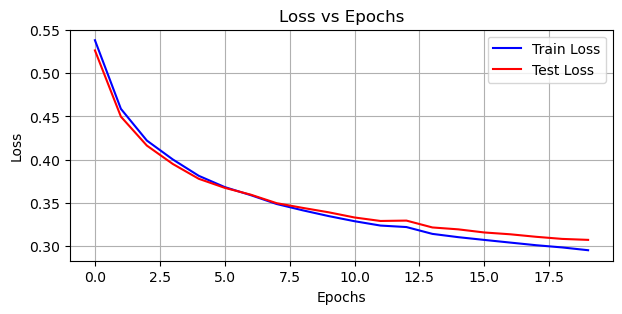

In [25]:
# Grafico de línea loss vs epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))
plt.plot(train_loss, linestyle='-',color='b', label='Train Loss')
plt.plot(test_loss, linestyle='-', color='r', label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

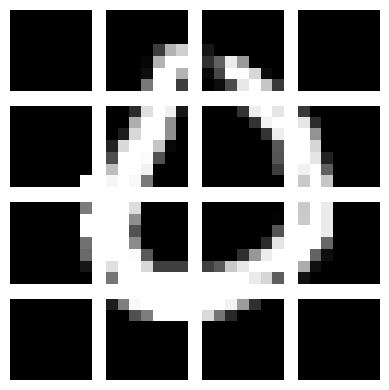

In [26]:
r, c = 4,4
fig = plt.figure(figsize=(c,r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r,c,ix+1)
        ax.imshow(train_images[2500,_r,_c].cpu().numpy(), cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()

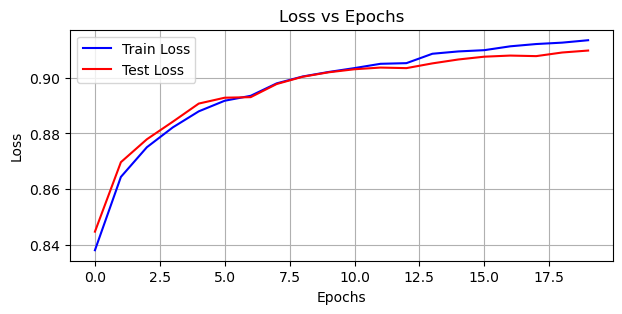

In [27]:
# Grafico accuracy
plt.figure(figsize=(7, 3))
plt.plot(train_accuracy, linestyle='-',color='b', label='Train Loss')
plt.plot(test_accuracy, linestyle='-', color='r', label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()